In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import random

%matplotlib inline

In [4]:
df = pd.read_csv('../uniprotkb_AND_model_organism_10090_2024_12_16.csv', sep=',', header=0)

print(df.head())     
print(df.columns)    
print(len(df))       

        Entry        Entry Name  \
0  A0A075F5C6  A0A075F5C6_MOUSE   
1  A0A087WPF7       AUTS2_MOUSE   
2  A0A087WRK1  A0A087WRK1_MOUSE   
3  A0A087WRT4  A0A087WRT4_MOUSE   
4  A0A087WSP5  A0A087WSP5_MOUSE   

                                       Protein names  \
0  Heat shock factor 1 (Heat shock transcription ...   
1       Autism susceptibility gene 2 protein homolog   
2  Predicted gene, 20814 (Predicted gene, 20855) ...   
3                            FAT atypical cadherin 1   
4   Signal transducer and activator of transcription   

                                          Gene Names              Organism  \
0                                               Hsf1  Mus musculus (Mouse)   
1                                     Auts2 Kiaa0442  Mus musculus (Mouse)   
2  Gm20905 Gm20814 Gm20835 Gm20850 Gm20855 Gm2086...  Mus musculus (Mouse)   
3                                               Fat1  Mus musculus (Mouse)   
4                                              Stat1  Mus musc

In [5]:
interpro_sets = []
for val in df['InterPro'].fillna(''):
    val = val.strip()
    if val == '':
        interpro_sets.append(set())
    else:
        splitted = [x for x in val.split(';') if x != '']
        interpro_sets.append(set(splitted))

for i in range(5):
    print(f"Ligne {i}: {interpro_sets[i]}")

Ligne 0: {'IPR036390', 'IPR027725', 'IPR000232', 'IPR036388', 'IPR010542'}
Ligne 1: {'IPR023246'}
Ligne 2: {'IPR051443', 'IPR006888'}
Ligne 3: {'IPR001881', 'IPR002126', 'IPR020894', 'IPR039808', 'IPR013320', 'IPR000152', 'IPR000742', 'IPR015919', 'IPR001791', 'IPR049883', 'IPR018097', 'IPR009030'}
Ligne 4: {'IPR013801', 'IPR015988', 'IPR000980', 'IPR036535', 'IPR038295', 'IPR013800', 'IPR035859', 'IPR048988', 'IPR036860', 'IPR001217', 'IPR012345', 'IPR008967', 'IPR022752', 'IPR013799'}


In [6]:
print(len(interpro_sets))

85870


# Statistiques générales

In [7]:
N = len(interpro_sets)
n_pairs = 1000000 

random_pairs = set()
while len(random_pairs) < n_pairs:
    i, j = random.sample(range(N), 2)
    if i > j:
        i, j = j, i
    random_pairs.add((i, j))

random_pairs = list(random_pairs)

print(f"Nombre de protéines: {N}")
print(f"Nombre de paires aléatoires: {len(random_pairs)}")


Nombre de protéines: 85870
Nombre de paires aléatoires: 1000000


In [27]:
no_ec_number = 0
for val in df['EC number'].fillna(''):
    val = val.strip()
    if val == '':
        no_ec_number += 1

print(f"Nombre de protéines sans EC number (non-labellisées): {no_ec_number}")
print(f"Nombre de protéines avec EC number (labellisées): {N - no_ec_number}")
print(f"Proportion de protéines sans EC number (non labellisées): {no_ec_number / N:.2f}")
print(f"Proportion de protéines avec EC number (labellisées): {(N - no_ec_number) / N:.2f}")

Nombre de protéines sans EC number (non-labellisées): 75336
Nombre de protéines avec EC number (labellisées): 10534
Proportion de protéines sans EC number (non labellisées): 0.88
Proportion de protéines avec EC number (labellisées): 0.12


# Etude des pourcentages de similarité

In [8]:
def jaccard_similarity(set_a, set_b):
    inter = len(set_a & set_b)
    uni = len(set_a | set_b)
    return inter / uni if uni != 0 else 0


In [9]:
def compute_jaccard_for_pairs(pairs_chunk, interpro_sets):
    """
    Calcule la similarité de Jaccard pour la liste de paires `pairs_chunk`.
    pairs_chunk est une liste de tuples (i, j).
    Retourne une liste de similarités (float).
    """
    results = []
    for (i, j) in pairs_chunk:
        set_i = interpro_sets[i]
        set_j = interpro_sets[j]
        sim = jaccard_similarity(set_i, set_j)
        results.append(sim)
    return results

num_cores = multiprocessing.cpu_count()
print(f"Nombre de cœurs détectés : {num_cores}")


Nombre de cœurs détectés : 4


In [10]:
chunk_size = 50000

chunks = []
for start_idx in range(0, len(random_pairs), chunk_size):
    end_idx = min(start_idx + chunk_size, len(random_pairs))
    chunk = random_pairs[start_idx:end_idx]
    chunks.append(chunk)

print(f"Nombre de chunks: {len(chunks)}")

# Lancement en parallèle
all_similarities = []

results = Parallel(n_jobs=num_cores)(
    delayed(compute_jaccard_for_pairs)(c, interpro_sets)
    for c in chunks
)

# 'results' est une liste de listes, on concatène tout
for partial in results:
    all_similarities.extend(partial)

print(f"Total de similarités calculées: {len(all_similarities)}")


Nombre de chunks: 20
Total de similarités calculées: 1000000


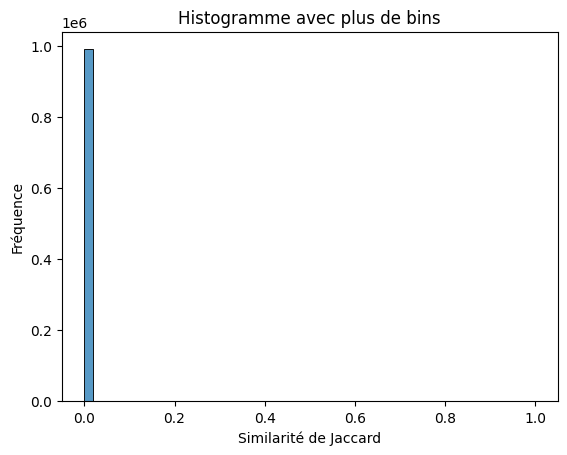

In [11]:
sns.histplot(all_similarities, bins=50, kde=False)
plt.title("Histogramme avec plus de bins")
plt.xlabel("Similarité de Jaccard")
plt.ylabel("Fréquence")
plt.show()

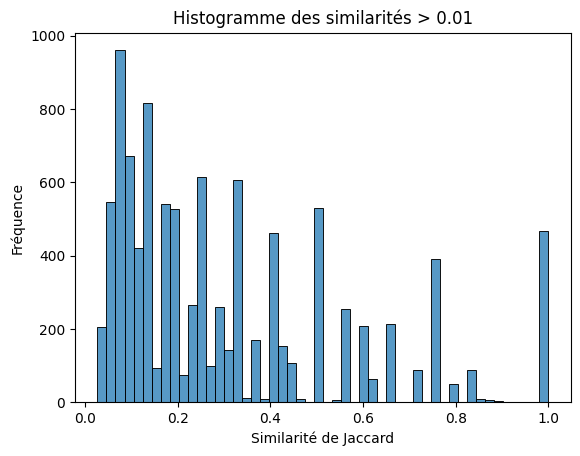

In [12]:
threshold = 0.01  # par exemple
filtered_sims = [x for x in all_similarities if x > threshold]

sns.histplot(filtered_sims, bins=50, kde=False)
plt.title(f"Histogramme des similarités > {threshold}")
plt.xlabel("Similarité de Jaccard")
plt.ylabel("Fréquence")
plt.show()

# Nombre de protéines par EC Number

Nombre d'EC numbers: 11782


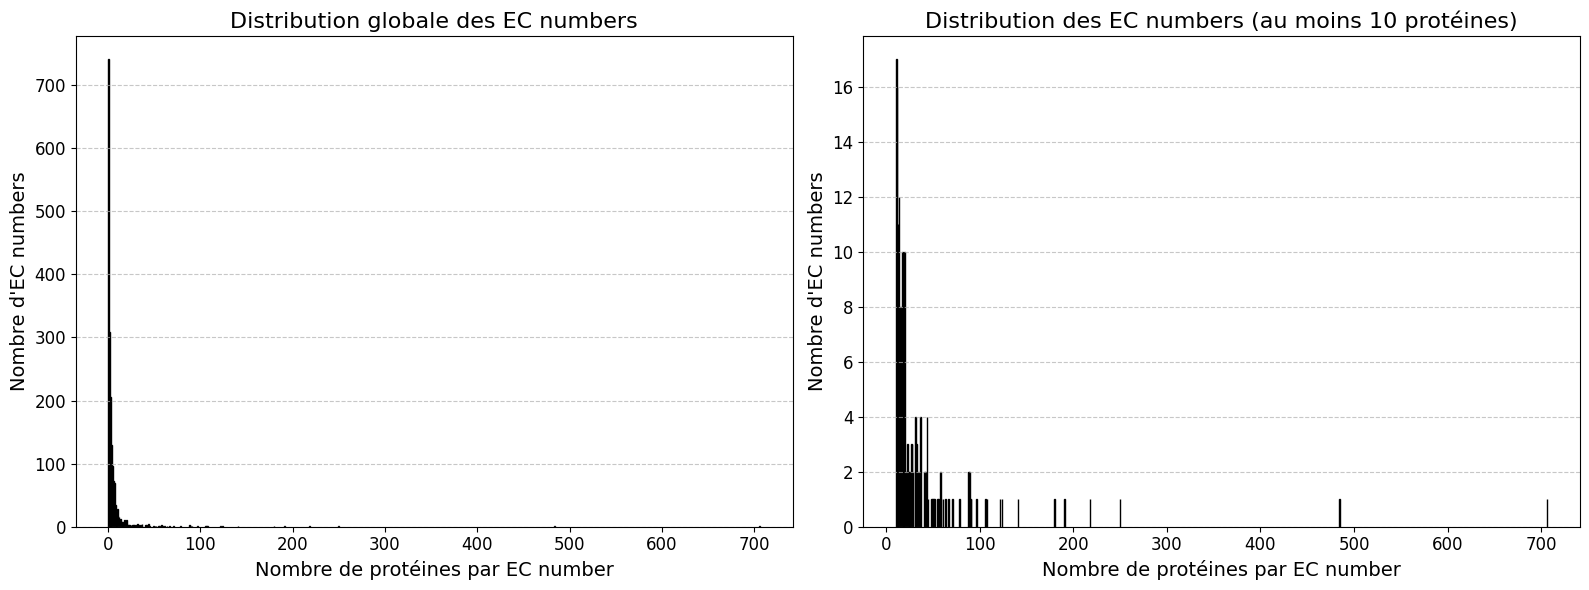

In [25]:
ec_numbers = []
for val in df['EC number'].fillna(''):
    val = val.strip()
    if val != '':
        splitted = [x for x in val.split(';') if x != '']
        ec_numbers.extend(splitted)

print(f"Nombre d'EC numbers: {len(ec_numbers)}")

ec_numbers = pd.Series(ec_numbers)

# Comptage des EC numbers
ec_numbers_counts = ec_numbers.value_counts()

# Filtrer les EC numbers avec au moins 10 occurrences
ec_numbers_counts_filtered = ec_numbers_counts[ec_numbers_counts > 10]

# Distribution des fréquences pour tous les EC numbers
freq_counts_all = ec_numbers_counts.value_counts()

# Distribution des fréquences pour les EC numbers filtrés
freq_counts_filtered = ec_numbers_counts_filtered.value_counts()

# Création des deux graphiques côte à côte
plt.figure(figsize=(16, 6))

# Graphique 1 : Distribution pour tous les EC numbers
plt.subplot(1, 2, 1)
plt.bar(freq_counts_all.index, freq_counts_all.values, color='skyblue', edgecolor='black')
plt.xlabel("Nombre de protéines par EC number", fontsize=14)
plt.ylabel("Nombre d'EC numbers", fontsize=14)
plt.title("Distribution globale des EC numbers", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Graphique 2 : Distribution pour les EC numbers filtrés
plt.subplot(1, 2, 2)
plt.bar(freq_counts_filtered.index, freq_counts_filtered.values, color='lightcoral', edgecolor='black')
plt.xlabel("Nombre de protéines par EC number", fontsize=14)
plt.ylabel("Nombre d'EC numbers", fontsize=14)
plt.title("Distribution des EC numbers (au moins 10 protéines)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher les graphiques
plt.tight_layout()
plt.show()

